In [52]:
import numpy as np
import pandas as pd

In [87]:
df = pd.read_csv("formQuestions.csv")
df.head()

,FormNumber,Question
0,1,Additional Comments
1,1,Audio used in this course was effective in lea...
2,1,Course Objectives were clearly indicated in th...
3,1,Grading practices for this course were clear
4,1,Grading practices for this course were consist...


In [88]:
df.count()

FormNumber    1700
Question      1700
dtype: int64

In [89]:
questions = df["Question"].dropna().tolist()
len(questions)

1700

In [90]:
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(questions)

In [91]:
from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=100, random_state=42)
# X_reduced = svd.fit_transform(X_tfidf)

# ------------------------------------------
# 4. Find optimal k (Elbow + Silhouette)
inertia = []
silhouette = []
k_range = range(2, 100)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_reduced, labels))

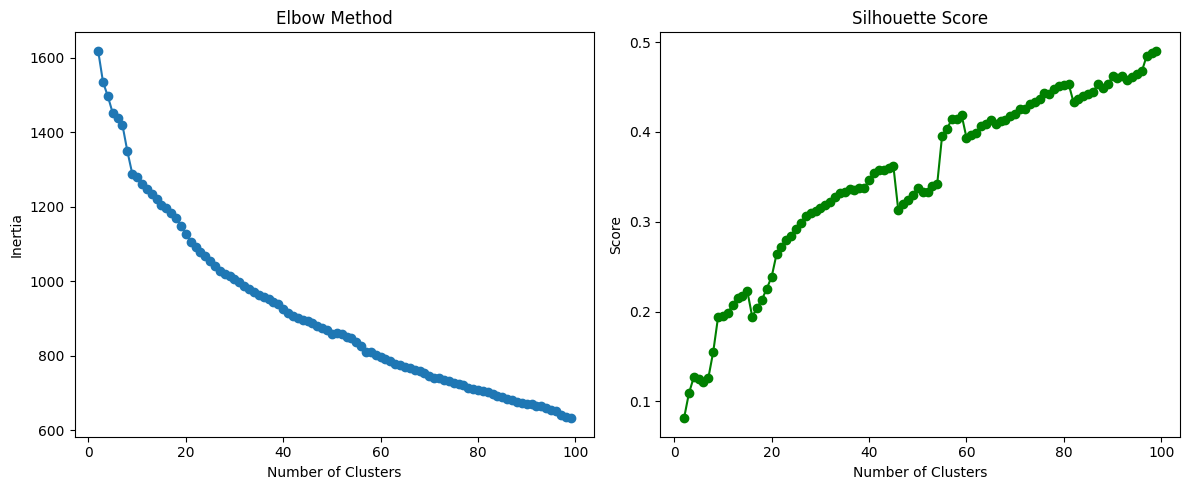

In [92]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

# Plot Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [93]:
optimal_k = sil_scores.index(max(sil_scores)) + 2  # +2 because range starts from 2
optimal_k = 55
final_model = KMeans(n_clusters=optimal_k, random_state=42)
final_model.fit(X_tfidf)
df['Cluster'] = final_model.labels_


In [94]:
# 7. Extract keywords and topic headline per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = final_model.cluster_centers_.argsort()[:, ::-1]

cluster_keywords = []
cluster_headlines = []

terms = vectorizer.get_feature_names_out()

# Loop through each cluster
for i in range(optimal_k):
    # Find all rows belonging to cluster i
    cluster_indices = df[df['Cluster'] == i].index.tolist()
    
    # Average TF-IDF scores across all documents in this cluster
    cluster_tfidf_matrix = X_tfidf[cluster_indices]
    mean_tfidf = cluster_tfidf_matrix.mean(axis=0)

    # Get top 5 terms
    top_indices = np.asarray(mean_tfidf).flatten().argsort()[::-1][:5]
    top_terms = [terms[j] for j in top_indices]

    # Format
    keywords_str = ", ".join(top_terms)
    headline_str = "Topic: " + " ".join(top_terms[:3]).title()

    cluster_keywords.append(keywords_str)
    cluster_headlines.append(headline_str)

# Map back to DataFrame
cluster_info = {
    i: {"keywords": cluster_keywords[i], "headline": cluster_headlines[i]}
    for i in range(optimal_k)
}

df['Topic_Keywords'] = df['Cluster'].map(lambda x: cluster_info[x]["keywords"])
df['Topic_Headline'] = df['Cluster'].map(lambda x: cluster_info[x]["headline"])

In [95]:
df.tail()

,FormNumber,Question,Cluster,Topic_Keywords,Topic_Headline
1695,4647,The instructor presented the material in a wel...,39,"clear, presented, manner, material, instructor",Topic: Clear Presented Manner
1696,4647,The instructor presented understandable lectures.,23,"lectures, organized, presented, understandable...",Topic: Lectures Organized Presented
1697,4647,"The instructor was available (in class, in the...",49,"available, students, assistant, assistance, ou...",Topic: Available Students Assistant
1698,4647,The instructor was concerned with the students...,41,"encouraged, participation, questions, instruct...",Topic: Encouraged Participation Questions
1699,4647,Work assigned was a useful tool for learning t...,20,"learning, facilitated, sessions, assignments, ...",Topic: Learning Facilitated Sessions


In [96]:
df.to_csv("tblclusters55.csv")